color correction

In [ ]:
pip install opencv-python

In [ ]:
import sys
import numpy as np
import cv2
import math

THRESHOLD_RATIO = 2000
MIN_AVG_RED = 60
MAX_HUE_SHIFT = 120
BLUE_MAGIC_VALUE = 1.2
SAMPLE_SECONDS = 2 # Extracts color correction from every N seconds

def hue_shift_red(mat, h):

    U = math.cos(h * math.pi / 180)
    W = math.sin(h * math.pi / 180)

    r = (0.299 + 0.701 * U + 0.168 * W) * mat[..., 0]
    g = (0.587 - 0.587 * U + 0.330 * W) * mat[..., 1]
    b = (0.114 - 0.114 * U - 0.497 * W) * mat[..., 2]

    return np.dstack([r, g, b])

def normalizing_interval(array):

    high = 255
    low = 0
    max_dist = 0

    for i in range(1, len(array)):
        dist = array[i] - array[i-1]
        if(dist > max_dist):
            max_dist = dist
            high = array[i]
            low = array[i-1]

    return (low, high)

def apply_filter(mat, filt):

    r = mat[..., 0]
    g = mat[..., 1]
    b = mat[..., 2]

    r = r * filt[0] + g*filt[1] + b*filt[2] + filt[4]*255
    g = g * filt[6] + filt[9] * 255
    b = b * filt[12] + filt[14] * 255

    filtered_mat = np.dstack([r, g, b])
    filtered_mat = np.clip(filtered_mat, 0, 255).astype(np.uint8)

    return filtered_mat

def get_filter_matrix(mat):

    mat = cv2.resize(mat, (256, 256))

    # Get average values of RGB
    avg_mat = np.array(cv2.mean(mat)[:3], dtype=np.uint8)

    # Find hue shift so that average red reaches MIN_AVG_RED
    new_avg_r = avg_mat[0]
    hue_shift = 0
    while(new_avg_r < MIN_AVG_RED):

        shifted = hue_shift_red(avg_mat, hue_shift)
        new_avg_r = np.sum(shifted)
        hue_shift += 1
        if hue_shift > MAX_HUE_SHIFT:
            new_avg_r = MIN_AVG_RED

    # Apply hue shift to whole image and replace red channel
    shifted_mat = hue_shift_red(mat, hue_shift)
    new_r_channel = np.sum(shifted_mat, axis=2)
    new_r_channel = np.clip(new_r_channel, 0, 255)
    mat[..., 0] = new_r_channel

    # Get histogram of all channels
    hist_r = hist = cv2.calcHist([mat], [0], None, [256], [0,256])
    hist_g = hist = cv2.calcHist([mat], [1], None, [256], [0,256])
    hist_b = hist = cv2.calcHist([mat], [2], None, [256], [0,256])

    normalize_mat = np.zeros((256, 3))
    threshold_level = (mat.shape[0]*mat.shape[1])/THRESHOLD_RATIO
    for x in range(256):

        if hist_r[x] < threshold_level:
            normalize_mat[x][0] = x

        if hist_g[x] < threshold_level:
            normalize_mat[x][1] = x

        if hist_b[x] < threshold_level:
            normalize_mat[x][2] = x

    normalize_mat[255][0] = 255
    normalize_mat[255][1] = 255
    normalize_mat[255][2] = 255

    adjust_r_low, adjust_r_high = normalizing_interval(normalize_mat[..., 0])
    adjust_g_low, adjust_g_high = normalizing_interval(normalize_mat[..., 1])
    adjust_b_low, adjust_b_high = normalizing_interval(normalize_mat[..., 2])


    shifted = hue_shift_red(np.array([1, 1, 1]), hue_shift)
    shifted_r, shifted_g, shifted_b = shifted[0][0]

    red_gain = 256 / (adjust_r_high - adjust_r_low)
    green_gain = 256 / (adjust_g_high - adjust_g_low)
    blue_gain = 256 / (adjust_b_high - adjust_b_low)

    redOffset = (-adjust_r_low / 256) * red_gain
    greenOffset = (-adjust_g_low / 256) * green_gain
    blueOffset = (-adjust_b_low / 256) * blue_gain

    adjust_red = shifted_r * red_gain
    adjust_red_green = shifted_g * red_gain
    adjust_red_blue = shifted_b * red_gain * BLUE_MAGIC_VALUE

    return np.array([
        adjust_red, adjust_red_green, adjust_red_blue, 0, redOffset,
        0, green_gain, 0, 0, greenOffset,
        0, 0, blue_gain, 0, blueOffset,
        0, 0, 0, 1, 0,
    ])

def correct(mat):
    original_mat = mat.copy()

    filter_matrix = get_filter_matrix(mat)

    corrected_mat = apply_filter(original_mat, filter_matrix)
    corrected_mat = cv2.cvtColor(corrected_mat, cv2.COLOR_RGB2BGR)

    return corrected_mat

def correct_image(input_path, output_path):
    mat = cv2.imread(input_path)
    rgb_mat = cv2.cvtColor(mat, cv2.COLOR_BGR2RGB)

    corrected_mat = correct(rgb_mat)

    cv2.imwrite(output_path, corrected_mat)

    preview = mat.copy()
    width = preview.shape[1] // 2
    preview[::, width:] = corrected_mat[::, width:]

    preview = cv2.resize(preview, (960, 540))

    return cv2.imencode('.png', preview)[1].tobytes()



In [ ]:
correct_image('example2.jpeg', 'example2_colorCorrected.jpg')

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xc0\x00\x00\x02\x1c\x08\x02\x00\x00\x00\xb6?P,\x00\x00 \x00IDATx\x01\\\xc1\xc1\x8ed\xc9r\x1cP3\xf3\x88\x9b\xd5\xdd\x03\x02Zh/\xe8c\x05\x90\xd0G\n\x90\x08\x02\xdaj^W\xe5\rw3e\xe5\xbc\xd9\xf0\x1c>\xfe\xed\xdf\x01\x8aJ \xa9\xbb\xf9\x86oqZ\\\xce\xf0\x05\xb4P\xe0\xcc$\x96J\xd2\xcc$)\x15\x88\x17\xdbU\xe51\x88\x97\xaa:\xe7H\xc2\x1bII\xb6\x93\x00\x01\x90@R\xdel\x03\xa8\xaa\x99\xa9\x92m\x00I\xf6\xdesZ\xd4 $\x93TifB\x88\x9a\x19\x02\x92\xdc&91\xdf\xe0\x00\x90\x94\x84d\xde\xf463@l\x83Z{\xdb\xc3\xb8OS\xf5b{\xad\xd5\xdd@$u\x8f$\x92@\x12H"8\x1e\x00I\xf4\x8dI\xec\x90L"\t/\xc1\x0bE\xdby#\x08\x81\xe0\xcb\xccT\x15\x80\x99)\xd5xH\x8a\xec\x99\xb5.\xd2\xddS\xc5\xfbyW\xad\xc4$=\x03\xe2\xb1\xae\xdb\xae*\x92\xb6%\xd9\x06\x10B \x1c\x14\xd3\x0e\xf1B\xc2NB\xc0$\x93\xac\xb5\x13wwU\x01` rl\x89 \xc7f\x00!\xf6^\xab=\t<\xb3\xf7\x16\xd5=$\r\x03|\xc1K\xa0bwSZZ\xd3\xbd\xaeu\xceAB\xfd\xa5\x92\xd8N"\xc9\x9e\xaa\xb2M\n\x88\x1d\xdbUJ\xb2Vu\x1b/\xf1\x0bI\xb1\xeca)\t\x81\x00\x9

denoising

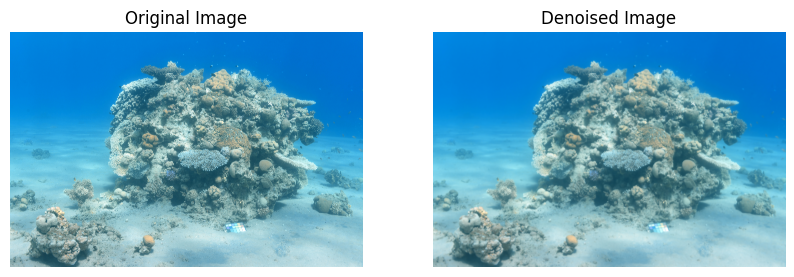

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.restoration import denoise_tv_bregman

# Load the image
image = io.imread('example2_colorCorrected.jpg')

# Convert image to floating point representation
image = img_as_float(image)

# Apply Total Variation denoising
denoised_image = denoise_tv_bregman(image, weight=0.1)

# Plot original and denoised images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_image)
plt.title('Denoised Image')
plt.axis('off')

plt.show()


DARK CHANNEL PRIOR

In [ ]:
pip install xlwt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 1.9 MB/s eta 0:00:00


In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import cv2

class GuidedFilter:

    # def __init__(self, I, radius=5, epsilon=0.4):
    def __init__(self, I, radius, epsilon):

        self._radius = 2 * radius + 1
        self._epsilon = epsilon
        self._I = self._toFloatImg(I)
        self._initFilter()

        # print('radius',self._radius)
        # print('epsilon',self._epsilon)

    def _toFloatImg(self, img):
        if img.dtype == np.float32:
            return img
        return ( 1.0 / 255.0 ) * np.float32(img)

    def _initFilter(self):
        I = self._I
        r = self._radius
        eps = self._epsilon

        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]

        # self._Ir_mean = cv2.blur(Ir, (r, r))
        # self._Ig_mean = cv2.blur(Ig, (r, r))
        # self._Ib_mean = cv2.blur(Ib, (r, r))
        #
        # Irr_var = cv2.blur(Ir ** 2, (r, r)) - self._Ir_mean ** 2 + eps
        # Irg_var = cv2.blur(Ir * Ig, (r, r)) - self._Ir_mean * self._Ig_mean
        # Irb_var = cv2.blur(Ir * Ib, (r, r)) - self._Ir_mean * self._Ib_mean
        # Igg_var = cv2.blur(Ig * Ig, (r, r)) - self._Ig_mean * self._Ig_mean + eps
        # Igb_var = cv2.blur(Ig * Ib, (r, r)) - self._Ig_mean * self._Ib_mean
        # Ibb_var = cv2.blur(Ib * Ib, (r, r)) - self._Ib_mean * self._Ib_mean + eps


        self._Ir_mean = cv2.blur(Ir, (r, r))
        self._Ig_mean = cv2.blur(Ig, (r, r))
        self._Ib_mean = cv2.blur(Ib, (r, r))

        Irr_var = cv2.blur(Ir ** 2, (r, r)) - self._Ir_mean ** 2 + eps
        Irg_var = cv2.blur(Ir * Ig, (r, r)) - self._Ir_mean * self._Ig_mean
        Irb_var = cv2.blur(Ir * Ib, (r, r)) - self._Ir_mean * self._Ib_mean
        Igg_var = cv2.blur(Ig * Ig, (r, r)) - self._Ig_mean * self._Ig_mean + eps
        Igb_var = cv2.blur(Ig * Ib, (r, r)) - self._Ig_mean * self._Ib_mean
        Ibb_var = cv2.blur(Ib * Ib, (r, r)) - self._Ib_mean * self._Ib_mean + eps


        Irr_inv = Igg_var * Ibb_var - Igb_var * Igb_var
        Irg_inv = Igb_var * Irb_var - Irg_var * Ibb_var
        Irb_inv = Irg_var * Igb_var - Igg_var * Irb_var
        Igg_inv = Irr_var * Ibb_var - Irb_var * Irb_var
        Igb_inv = Irb_var * Irg_var - Irr_var * Igb_var
        Ibb_inv = Irr_var * Igg_var - Irg_var * Irg_var

        I_cov = Irr_inv * Irr_var + Irg_inv * Irg_var + Irb_inv * Irb_var
        Irr_inv /= I_cov
        Irg_inv /= I_cov
        Irb_inv /= I_cov
        Igg_inv /= I_cov
        Igb_inv /= I_cov
        Ibb_inv /= I_cov

        self._Irr_inv = Irr_inv
        self._Irg_inv = Irg_inv
        self._Irb_inv = Irb_inv
        self._Igg_inv = Igg_inv
        self._Igb_inv = Igb_inv
        self._Ibb_inv = Ibb_inv

    def _computeCoefficients(self, p):
        r = self._radius
        I = self._I
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]


        p_mean = cv2.blur(p, (r, r))
        Ipr_mean = cv2.blur(Ir * p, (r, r))
        Ipg_mean = cv2.blur(Ig * p, (r, r))
        Ipb_mean = cv2.blur(Ib * p, (r, r))



        Ipr_cov = Ipr_mean - self._Ir_mean * p_mean
        Ipg_cov = Ipg_mean - self._Ig_mean * p_mean
        Ipb_cov = Ipb_mean - self._Ib_mean * p_mean

        ar = self._Irr_inv * Ipr_cov + self._Irg_inv * Ipg_cov + self._Irb_inv * Ipb_cov
        ag = self._Irg_inv * Ipr_cov + self._Igg_inv * Ipg_cov + self._Igb_inv * Ipb_cov
        ab = self._Irb_inv * Ipr_cov + self._Igb_inv * Ipg_cov + self._Ibb_inv * Ipb_cov

        b = p_mean - ar * self._Ir_mean - ag * self._Ig_mean - ab * self._Ib_mean

        ar_mean = cv2.blur(ar, (r, r))
        ag_mean = cv2.blur(ag, (r, r))
        ab_mean = cv2.blur(ab, (r, r))
        b_mean = cv2.blur(b, (r, r))

        return ar_mean, ag_mean, ab_mean, b_mean

    def _computeOutput(self, ab, I):

        ar_mean, ag_mean, ab_mean, b_mean = ab
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]
        q = ar_mean * Ir + ag_mean * Ig + ab_mean * Ib + b_mean
        return q

    def filter(self, p):

        p_32F = self._toFloatImg(p)

        ab = self._computeCoefficients(p)
        return self._computeOutput(ab, self._I)



In [ ]:
# from GuidedFilter import GuidedFilter

import datetime
import os
import math
import numpy as np
import cv2
from PIL import Image
import os
import numpy as np
import cv2
import natsort
import xlwt


# 用于排序时存储原来像素点位置的数据结构
class Node(object):
    def __init__(self, x, y, value):
        self.x = x
        self.y = y
        self.value = value

    def printInfo(self):
        print(self.x, self.y, self.value)


# 获取最小值矩阵
# 获取BGR三个通道的最小值
def getMinChannel(img):
    # 输入检查
    if len(img.shape) == 3 and img.shape[2] == 3:
        pass
    else:
        print("bad image shape, input must be color image")
        return None
    imgGray = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    localMin = 255

    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            localMin = 255
            for k in range(0, 3):
                if img.item((i, j, k)) < localMin:
                    localMin = img.item((i, j, k))
            imgGray[i, j] = localMin
    return imgGray


# 获取暗通道
def getDarkChannel(img, blockSize):
    # 输入检查
    if len(img.shape) == 2:
        pass
    else:
        print("bad image shape, input image must be two demensions")
        return None

    # blockSize检查
    if blockSize % 2 == 0 or blockSize < 3:
        print('blockSize is not odd or too small')
        return None
    # print('blockSize', blockSize)
    # 计算addSize
    addSize = int((blockSize - 1) / 2)
    newHeight = img.shape[0] + blockSize - 1
    newWidth = img.shape[1] + blockSize - 1

    # 中间结果
    imgMiddle = np.zeros((newHeight, newWidth))
    imgMiddle[:, :] = 255
    # print('imgMiddle',imgMiddle)
    # print('type(newHeight)',type(newHeight))
    # print('type(addSize)',type(addSize))
    imgMiddle[addSize:newHeight - addSize, addSize:newWidth - addSize] = img
    # print('imgMiddle', imgMiddle)
    imgDark = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    localMin = 255

    for i in range(addSize, newHeight - addSize):
        for j in range(addSize, newWidth - addSize):
            localMin = 255
            for k in range(i - addSize, i + addSize + 1):
                for l in range(j - addSize, j + addSize + 1):
                    if imgMiddle.item((k, l)) < localMin:
                        localMin = imgMiddle.item((k, l))
            imgDark[i - addSize, j - addSize] = localMin

    return imgDark


# 获取全局大气光强度
def getAtomsphericLight(darkChannel, img, meanMode=False, percent=0.001):
    size = darkChannel.shape[0] * darkChannel.shape[1]
    height = darkChannel.shape[0]
    width = darkChannel.shape[1]

    nodes = []

    # 用一个链表结构(list)存储数据
    for i in range(0, height):
        for j in range(0, width):
            oneNode = Node(i, j, darkChannel[i, j])
            nodes.append(oneNode)

    # 排序
    nodes = sorted(nodes, key=lambda node: node.value, reverse=True)

    atomsphericLight = 0

    # 原图像像素过少时，只考虑第一个像素点
    if int(percent * size) == 0:
        for i in range(0, 3):
            if img[nodes[0].x, nodes[0].y, i] > atomsphericLight:
                atomsphericLight = img[nodes[0].x, nodes[0].y, i]
        return atomsphericLight

    # 开启均值模式
    if meanMode:
        sum = 0
        for i in range(0, int(percent * size)):
            for j in range(0, 3):
                sum = sum + img[nodes[i].x, nodes[i].y, j]

        atomsphericLight = int(sum / (int(percent * size) * 3))
        return atomsphericLight

    # 获取暗通道前0.1%(percent)的位置的像素点在原图像中的最高亮度值
    for i in range(0, int(percent * size)):
        for j in range(0, 3):
            if img[nodes[i].x, nodes[i].y, j] > atomsphericLight:
                atomsphericLight = img[nodes[i].x, nodes[i].y, j]

    return atomsphericLight


# 恢复原图像
# Omega 去雾比例 参数
# t0 最小透射率值
def getRecoverScene(img, omega=0.95, t0=0.1, blockSize=15, meanMode=False, percent=0.001):

    gimfiltR = 50  # 引导滤波时半径的大小
    eps = 10 ** -3  # 引导滤波时epsilon的值


    imgGray = getMinChannel(img)
    # print('imgGray', imgGray)
    imgDark = getDarkChannel(imgGray, blockSize=blockSize)
    atomsphericLight = getAtomsphericLight(imgDark, img, meanMode=meanMode, percent=percent)

    imgDark = np.float64(imgDark)
    transmission = 1 - omega * imgDark / atomsphericLight

    guided_filter = GuidedFilter(img, gimfiltR, eps)
    transmission = guided_filter.filter(transmission)

    # 防止出现t小于0的情况
    # 对t限制最小值为0.1

    transmission = np.clip(transmission, t0, 0.9)

    sceneRadiance = np.zeros(img.shape)
    for i in range(0, 3):
        img = np.float64(img)
        sceneRadiance[:, :, i] = (img[:, :, i] - atomsphericLight) / transmission + atomsphericLight

    sceneRadiance = np.clip(sceneRadiance, 0, 255)
    sceneRadiance = np.uint8(sceneRadiance)

    return transmission,sceneRadiance



np.seterr(over='ignore')
if __name__ == '__main__':
    pass


path = "example2.jpeg"
files = "example2.jpeg"
files =  natsort.natsorted(files)

for i in range(len(files)):
    file = files[i]
    filepath = path + "/" + file
    prefix = file.split('.')[0]
    if os.path.isfile(filepath):
        print('********    file   ********',file)
        img = cv2.imread(file)
        transmission, sceneRadiance = getRecoverScene(img)
        cv2.imwrite('_DCP_TM.jpg', np.uint8(transmission * 255))
        cv2.imwrite('_DCP.jpg', sceneRadiance)